In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jobathonfebruary2022/test_1zqHu22.csv
/kaggle/input/jobathonfebruary2022/sample_submission_JPlpRcN.csv
/kaggle/input/jobathonfebruary2022/train_0OECtn8.csv


In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [3]:
!pip install tune-sklearn ray[tune]

     |████████████████████████████████| 40 kB 519 kB/s            


In [4]:
!pip install pycaret

     |████████████████████████████████| 301 kB 290 kB/s            
     |████████████████████████████████| 24.2 MB 1.8 MB/s            
     |████████████████████████████████| 15.6 MB 60.5 MB/s            
     |████████████████████████████████| 167 kB 66.5 MB/s            
     |████████████████████████████████| 10.4 MB 58.6 MB/s            
     |████████████████████████████████| 114 kB 47.6 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 636 kB 57.7 MB/s            
     |████████████████████████████████| 25.9 MB 802 kB/s             
     |████████████████████████████████| 184 kB 58.5 MB/s            
     |████████████████████████████████| 1.0 MB 24.6 MB/s            
     |████████████████████████████████| 14.8 MB 61.2 MB/s            
     |████████████████████████████████| 58 kB 5.3 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 79 kB 7.3 MB/s             
  Created wh

In [5]:
from pycaret.regression import *

In [6]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [7]:
KAGGLE=True

In [8]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

Read Data Files

In [9]:
train = pd.read_csv(path+'train_0OECtn8.csv')
test = pd.read_csv(path+'test_1zqHu22.csv')
subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [10]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [17]:
print(train.columns)
print(test.columns)

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score'],
      dtype='object')
Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views'],
      dtype='object')


Simple and Advanced Feature Engineering

In [18]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)
    
    #to have video id without target encoding
    train['video_id_raw']=train['video_id'].copy()
    
def gen_agg(train,test):
    #user_id aggregate features
    user_agg = train[['user_id','video_id','category_id']].groupby('user_id').agg('nunique').reset_index()
    user_agg = user_agg.rename({'video_id':'user_video_count','category_id':'user_category_count'},axis=1)
    train = pd.merge(train, user_agg, how='left', on='user_id')
    test = pd.merge(test, user_agg, how='left', on='user_id')
    
    
    #category_id aggregate features
    cat_agg = train[['category_id','user_id','video_id','age','gender','profession']] \
                        .groupby('category_id') \
                        .agg({'user_id':'nunique','video_id':'nunique', \
                             'age':'mean','gender':'mean','profession':'mean'}) \
                        .reset_index()
    cat_agg = cat_agg.rename({'user_id':'category_user_count',
                              'video_id':'category_video_count',
                              'age':'category_age_mean',
                              'gender':'category_gender_mean',
                              'profession':'category_profession_mean',
                             }, axis=1)
    train = pd.merge(train, cat_agg, how='left', on='category_id')
    test = pd.merge(test, cat_agg, how='left', on='category_id')    
    
    #video_id aggregate features
    video_agg = train[['video_id','age','gender','profession']] \
                        .groupby('video_id') \
                        .agg('mean') \
                        .reset_index() 
    video_agg = video_agg.rename({'age':'video_age_mean',
                              'gender':'video_gender_mean',
                              'profession':'video_profession_mean',
                             },axis=1)
    train = pd.merge(train, video_agg, how='left', on='video_id')
    test = pd.merge(test, video_agg, how='left', on='video_id')
    
    return train,test
        

In [19]:
preproc(train,test)

In [20]:
train,test = gen_agg(train,test)

In [21]:
print(train.columns)
train.head()

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score', 'video_id_raw',
       'user_video_count', 'user_category_count', 'category_user_count',
       'category_video_count', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean', 'video_age_mean', 'video_gender_mean',
       'video_profession_mean'],
      dtype='object')


,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,video_id_raw,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean
0,1,19990,37,128,24,1,1,180,1000,4.33,128,3,2,635,2,24.816008,0.602911,0.922037,24.864811,0.602386,0.912525
1,2,5304,32,132,14,0,1,330,714,1.79,132,5,3,1507,4,24.884218,0.563053,0.862832,25.104735,0.569584,0.892396
2,3,1840,12,24,19,1,1,180,138,4.35,24,3,1,2020,6,24.836205,0.670352,0.883775,25.039640,0.681081,0.935135
3,4,12597,23,112,19,1,1,220,613,3.77,112,3,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044
4,5,13626,23,112,27,1,2,220,613,3.13,112,4,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044


In [22]:
targetcol = 'engagement_score'
target = train[targetcol]

In [23]:
exclude_cols =['row_id', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean',  'video_gender_mean',
       'video_profession_mean','video_id_raw',
            'video_age_mean',
        'video_age_ratio', 'video_profession_diff', 
        'video_profession_ratio', 'video_gender_diff', 'video_gender_ratio']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

13
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'engagement_score', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


In [24]:
catcols = []
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(len(catcols))
print(catcols)
print(len(numeric_cols))
print(numeric_cols)

0
[]
12
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


Model - Build- Evaluate-Tune- Predict

In [26]:

ct = ColumnTransformer(
     [
         ("targetenc",  TargetEncoder(cols=['user_id','category_id', 'video_id'],
                                                min_samples_leaf=2, smoothing=0.1) , ['user_id','category_id', 'video_id']),
      ],remainder='passthrough')

preprocessor = ('preproc',ct)

Initialize pycaret

In [29]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=False,
          use_gpu=True,
          )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 12)"


In [30]:
X= get_config('X')
print(len(X.columns))
print(list(X.columns))
X.head()

12
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


,user_id,category_id,video_id,age,gender,profession,followers,views,user_video_count,user_category_count,category_user_count,category_video_count
0,19990.0,37.0,128.0,24.0,1.0,1.0,180.0,1000.0,3.0,2.0,635.0,2.0
1,5304.0,32.0,132.0,14.0,0.0,1.0,330.0,714.0,5.0,3.0,1507.0,4.0
2,1840.0,12.0,24.0,19.0,1.0,1.0,180.0,138.0,3.0,1.0,2020.0,6.0
3,12597.0,23.0,112.0,19.0,1.0,1.0,220.0,613.0,3.0,2.0,1705.0,2.0
4,13626.0,23.0,112.0,27.0,1.0,2.0,220.0,613.0,4.0,2.0,1705.0,2.0


In [32]:
params ={'bagging_fraction':0.9952502960431285, 
         'bagging_freq':0,
         'boosting_type':'gbdt', 
         'colsample_bytree':0.8,
         'feature_fraction':0.4, 
         'importance_type':'split',
        'learning_rate':0.03690482570462122, 
         'max_depth':12,
        'min_child_samples':100, 
        'min_child_weight':0.001,
        'min_split_gain':0.2626290916915215,
        'n_estimators':151,
        'num_leaves':256, 
        'random_state':100, 
        'reg_alpha':1e-10,
        'reg_lambda':0.00696729047618253, 
        'subsample_for_bin':200000,
        }

In [33]:
%%time
lgbm = create_model('lightgbm',**params)
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5028,0.4600,0.6782,0.4100,0.1921,0.2446
1,0.5052,0.4491,0.6702,0.3911,0.1822,0.2436
2,0.5115,0.4730,0.6878,0.3865,0.1911,0.2863
3,0.5045,0.4524,0.6726,0.3874,0.1844,0.2263
4,0.5053,0.4566,0.6757,0.3979,0.1870,0.1990
5,0.5092,0.4607,0.6787,0.3822,0.1846,0.2265
6,0.4978,0.4376,0.6615,0.4007,0.1782,0.1924
7,0.5047,0.4551,0.6746,0.3952,0.1859,0.2363
8,0.4973,0.4333,0.6583,0.4013,0.1782,0.2410
9,0.5049,0.4520,0.6723,0.4019,0.1867,0.2630


CPU times: user 55.1 s, sys: 2.8 s, total: 57.9 s
Wall time: 32.9 s


LGBMRegressor(bagging_fraction=0.9952502960431285, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              device='gpu', feature_fraction=0.4, importance_type='split',
              learning_rate=0.03690482570462122, max_depth=12,
              min_child_samples=100, min_child_weight=0.001,
              min_split_gain=0.2626290916915215, n_estimators=151, n_jobs=-1,
              num_leaves=256, objective=None, random_state=100, reg_alpha=1e-10,
              reg_lambda=0.00696729047618253, silent='warn', subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

Tune LightGBM Model parameters with 50 iterations

In [34]:

tune_params = {
    'bagging_fraction': np.random.uniform( 0.6, 1, 25),
    'num_leaves': np.random.randint( 20, 150, 5),
    'subsample_for_bin': np.random.randint( 40000, 160000, 10000),
    'min_child_samples': np.random.randint(30, 200, 5),
    'reg_alpha': np.random.uniform( 0.01, 0.99),
    'reg_lambda': np.random.uniform( 0.01, 0.99),
    'feature_fraction': np.random.uniform(0.6, 1.0),
}


In [35]:
%%time
tuned_lgbm = tune_model(lgbm,optimize='r2',
                        search_library='scikit-optimize',
                        n_iter=50)
tuned_lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4958,0.4512,0.6717,0.4212,0.1905,0.2410
1,0.4984,0.4408,0.6639,0.4024,0.1805,0.2402
2,0.5062,0.4638,0.6811,0.3984,0.1892,0.2823
3,0.4989,0.4447,0.6669,0.3977,0.1830,0.2237
4,0.4992,0.4474,0.6689,0.4099,0.1850,0.1963
5,0.5034,0.4523,0.6726,0.3934,0.1829,0.2241
6,0.4921,0.4279,0.6542,0.4140,0.1761,0.1899
7,0.4998,0.4474,0.6689,0.4055,0.1843,0.2351
8,0.4910,0.4260,0.6527,0.4115,0.1767,0.2380
9,0.4985,0.4436,0.6660,0.4131,0.1851,0.2607


CPU times: user 54min 17s, sys: 4min 3s, total: 58min 20s
Wall time: 31min 51s


LGBMRegressor(bagging_fraction=0.6579004691375484, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              device='gpu', feature_fraction=0.4, importance_type='split',
              learning_rate=0.017126008965757278, max_depth=12,
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=256, objective=None,
              random_state=100, reg_alpha=1e-10, reg_lambda=1e-10,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [36]:
save_model(tuned_lgbm, 'tuned_lgbm_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['user_id',
                                                           'category_id',
                                                           'video_id', 'age',
                                                           'gender',
                                                           'profession',
                                                           'followers', 'views',
                                                           'user_video_count',
                                                           'user_category_count',
                                                           'category_user_count',
                                      

Tuned Light GBM Feature importances

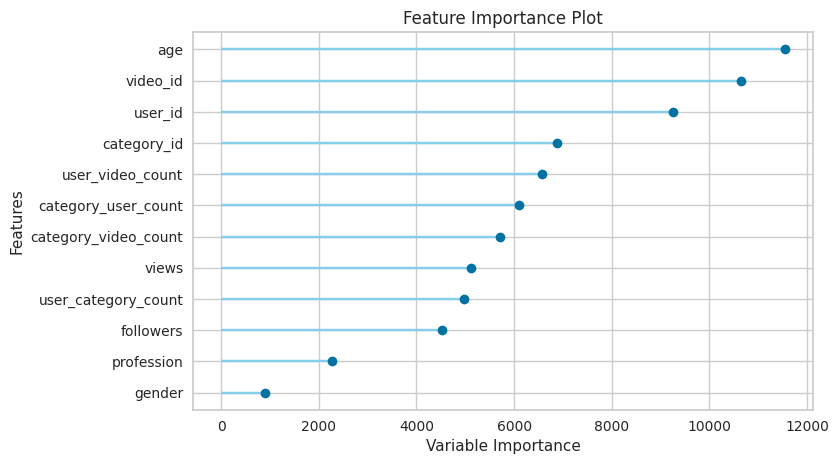

In [37]:
plot_model(tuned_lgbm,'feature_all')

xgboost model

In [38]:
%%time
xgbm=create_model('xgboost')
xgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4956,0.4634,0.6808,0.4056,0.1916,0.2409
1,0.5003,0.4538,0.6736,0.3848,0.1820,0.2410
2,0.5068,0.4748,0.6891,0.3841,0.1899,0.2768
3,0.4985,0.4598,0.6781,0.3773,0.1850,0.2234
4,0.4993,0.4616,0.6794,0.3913,0.1870,0.1947
5,0.5060,0.4711,0.6864,0.3681,0.1856,0.2241
6,0.4939,0.4414,0.6644,0.3956,0.1778,0.1897
7,0.5001,0.4587,0.6773,0.3905,0.1850,0.2329
8,0.4902,0.4366,0.6608,0.3968,0.1778,0.2363
9,0.4984,0.4559,0.6752,0.3968,0.1865,0.2505


CPU times: user 5.86 s, sys: 238 ms, total: 6.1 s
Wall time: 5.91 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)

# Tune XGBoost Model parameters with 100 iterations

In [39]:
%%time
tuned_xgbm = tune_model(xgbm,optimize='r2',
                        search_library='scikit-optimize',
                        n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4892,0.4480,0.6693,0.4254,0.1891,0.2367
1,0.4927,0.4372,0.6612,0.4073,0.1793,0.2368
2,0.5007,0.4608,0.6788,0.4023,0.1880,0.2772
3,0.4925,0.4420,0.6649,0.4014,0.1821,0.2209
4,0.4927,0.4428,0.6654,0.4160,0.1832,0.1920
5,0.4975,0.4503,0.6710,0.3961,0.1818,0.2208
6,0.4862,0.4244,0.6514,0.4189,0.1748,0.1867
7,0.4943,0.4427,0.6654,0.4116,0.1823,0.2312
8,0.4846,0.4238,0.6510,0.4145,0.1759,0.2339
9,0.4921,0.4412,0.6642,0.4163,0.1843,0.2528


CPU times: user 1h 4min, sys: 2min 22s, total: 1h 6min 23s
Wall time: 1h 2min 13s


In [40]:
save_model(tuned_xgbm, 'tuned_xgb_model')
tuned_xgbm

Transformation Pipeline and Model Successfully Saved


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)

In [44]:
%%time
catboost=create_model('catboost')
catboost

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4961,0.4593,0.6777,0.4109,0.1907,0.2402
1,0.4983,0.4492,0.6702,0.3911,0.1815,0.2379
2,0.5076,0.4756,0.6897,0.3831,0.1906,0.2788
3,0.4994,0.4539,0.6737,0.3853,0.1841,0.2242
4,0.4993,0.4583,0.6770,0.3956,0.1860,0.1948
5,0.5038,0.4626,0.6801,0.3797,0.1841,0.2232
6,0.4936,0.4374,0.6613,0.4011,0.1773,0.1894
7,0.4999,0.4556,0.6750,0.3945,0.1846,0.2335
8,0.4907,0.4356,0.6600,0.3982,0.1779,0.2365
9,0.4970,0.4521,0.6724,0.4019,0.1859,0.2557


CPU times: user 2min 23s, sys: 24.7 s, total: 2min 47s
Wall time: 2min 13s


In [ ]:
# %%time
# tuned_catboost = tune_model(catboost,optimize='r2',
#                             search_library='tune-sklearn',
#                         n_iter=50)

In [ ]:
# save_model(tuned_catboost, 'tuned_catboost_model')
# tuned_catboost

In [ ]:
# %%time
# rf=create_model('rf')
# rf

In [ ]:
# rf.get_params()

In [ ]:
# %%time
# tuned_rf = tune_model(rf,optimize='r2',
#                         search_library='scikit-optimize',
#                         n_iter=1)

In [ ]:
# save_model(tuned_rf, 'tuned_randomforest_model')
# tuned_rf